In [2]:
### import needed packages and setup the database.
### Then retrieve the obscured quasar table


# This code block defined your token and makes it available as a 
#   system variable for the length of your current session.
# 
# This will usually be the first code block in any script you write.
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
# async queries require token to be in --ident system variable
import sys
sys.argv.append("--ident="+token)
print("Your current token is "+token)

#Importing Pythong libraries to work with SciServer

import SciServer.CasJobs as CasJobs

#importing other libraries
import numpy as np
import StringIO
import pandas
from astropy.table import Table
import skimage.io
import urllib
import json
from scipy.interpolate import interp1d

# matplotlib plotting routines
import matplotlib.pyplot as plt
%matplotlib notebook
# install and import astroquery routine to import an SDSS spectrum
!conda install -y -n py27 -c astropy astroquery
from astroquery.sdss import SDSS
import astropy.units as u
from astropy.io import fits

# import astropy SkyCoord for working with astronomical coordinates
from astropy import coordinates as coords

# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

#retrieve the quasar table from casjobs
query = """
SELECT *
  from igmBellaireHS.jimmynewland.obscured_quasars as Q 
  """
# The method takes the query and the 'context' (= target database) as parameters, and possibly the token.
# This example uses mydb as context - the code makes a connection 
#   to the DR12 database, then runs the query in quick mode.
#   When the query succeeds, an "OK" message prints below.
quasars = CasJobs.executeQuery(query, 'mydb', 'StringIO') # query context changed to mydb to avoid time limit and using StringIO to avoid memory limit
# Convert to an astropy table for easier (though somewhat less computationally efficient) interfacing
quasars = Table.from_pandas(pandas.read_csv(quasars))

# Remove quasars without a valid plate-MJD-fiberID. Not sure what is going on with these
quasars = quasars[quasars['plate'] > 0]


Your current token is 636295e1234b47ca8a47e88b0ca2c8bc
Fetching package metadata ...........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/idies/anaconda3/envs/py27:
#
astroquery                0.3.8                    py27_0    astropy


/home/idies/anaconda3/envs/py27/lib/python2.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [3]:
# Print the quasar table and column names so we know what they are
print quasars
print quasars.colnames

   ra       dec     plate  mjd  ... reyes2008 mullaney2013 yuan2016 wise_forced
-------- ---------- ----- ----- ... --------- ------------ -------- -----------
6.381083  -10.67283   653 52145 ...      True         True     True        True
6.799583     0.3755   688 52203 ...     False        False    False        True
 7.11575 -0.7052222   688 52203 ...      True        False    False        True
7.220292 -0.2426667  3586 55181 ...      True        False    False        True
10.08463 -0.6759722  1905 53706 ...     False        False    False        True
11.05363  0.6018889  3590 55201 ...      True        False    False        True
12.54088 -0.6501667   692 52201 ...      True        False    False        True
13.81592 -0.7801667  4224 55481 ...     False        False    False        True
 14.0905  0.5432778   692 52201 ...      True        False    False        True
14.39146  0.2134167   692 52201 ...     False        False    False        True
     ...        ...   ...   ... ...     

In [4]:
# First, let's retieve spectra of two of the obscured quasars and plot them.
# To do this, we'll create a "helper" function that takes care of the intermediate steps.

# Function for returning a spectrum retrieved from the SDSS database
# The required inputs are just the desired plate, mjd, fiberid to identify the spectrum
# And optionally a redshift to convert observed wavelength to rest-wavelength
def getSpectrum(plate, MJD, fiberID, redshift=0.0):
    
    # Retrieve the spectrum as a "fits file HDU" list using pre-built astroquery.SDSS function.
    # note: it isn't important to know what a "fits file HDU" actually is, just a technical detail on how
    # SDSS (and many astronomers) store astronomical data
    hdulist = SDSS.get_spectra(plate=plate, mjd=MJD, fiberID=fiberID)[0]
    
    spec_in = hdulist[1].data # Get the hdu with the spectrum information in it
    #print Table(spec_in)
    
    # Create a new numpy structure to hold a more nicely formatted spectrum information
    spec = np.ndarray(len(spec_in),
                     dtype={'names':('logWave', 'wave', 'logWave_rest', 'wave_rest', 'flux', 'ivar', 'error'), 
                            'formats':(float, float, float, float, float, float, float)})
    
    spec['logWave'] = spec_in['loglam']
    spec['wave'] = 10.0**spec_in['loglam']
    spec['wave_rest'] = spec['wave']/(1 + redshift)
    spec['logWave_rest'] = np.log10(spec['wave_rest'])
    spec['flux'] = spec_in['flux']
    spec['ivar'] = spec_in['ivar']
    spec['error'] = 1.0/np.sqrt(spec['ivar'])
    
    spec = spec[spec['ivar'] > 0.0]
    
    return spec
    

<IPython.core.display.Javascript object>


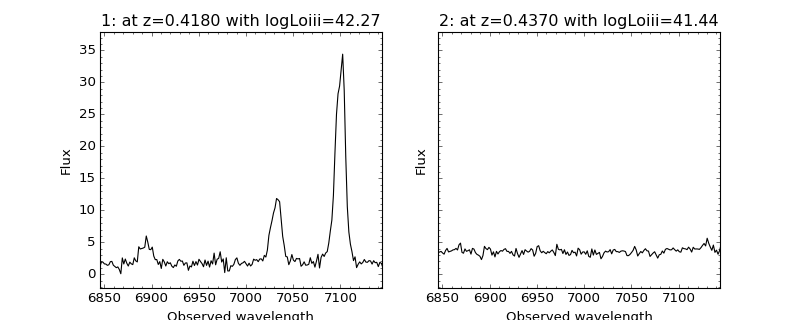


Once the plot is made, use the zoom and pan 
tool (buttons on the bottom) to look at
the wavelength range of 6800-7200 Angstroms

In quasar 1, you should see three strong strong emission lines
at 6900, 7040, and 7100 Angstroms which are from Hydrogen (Hbeta)
and twice ionized Oxygen ([O III]).

These emission lines are commonly seen in quasars and are produced
by T=10,000 K gas that is photoionized by ultraviolet emission from the
quasars accretion disk (which is itself around a nuclear supermassive black hole)

In quasar 2, these lines are substantially weaker and at slightly
different wavelengths. This is because quasar 2 is both at slightly higher redshift
and less luminous




In [5]:
# So lets get the spectra of a couple z=0.4 quasars and plot them
quasars_04 = quasars[(quasars['redshift'] > 0.4) & (quasars['redshift'] < 0.45)]
quasar1 = quasars_04[1]
quasar2 = quasars_04[0]

spec1 = getSpectrum(quasar1['plate'], quasar1['mjd'], quasar1['fiberid'], quasar1['redshift'])
spec2 = getSpectrum(quasar2['plate'], quasar2['mjd'], quasar2['fiberid'], quasar2['redshift'])

# Create a two panel figure, one for each quasar with x and y range initially the same
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

# Plot the first quasar
ax1.plot(spec1['wave'], spec1['flux'], color='black')
ax1.set_xlabel('Observed wavelength')
ax1.set_ylabel('Flux')
ax1.set_title('1: at z={:0.4f} with logLoiii={:0.2f}'.format(quasar1['redshift'], quasar1['logl_oiii']))
ax1.minorticks_on()

# Plot the second quasar
ax2.plot(spec2['wave'], spec2['flux'], color='black')
ax2.set_xlabel('Observed wavelength')
ax2.set_ylabel('Flux')
ax2.set_title('2: at z={:0.4f} with logLoiii={:0.2f}'.format(quasar2['redshift'], quasar2['logl_oiii']))


print """
Once the plot is made, use the zoom and pan 
tool (buttons on the bottom) to look at
the wavelength range of 6800-7200 Angstroms

In quasar 1, you should see three strong strong emission lines
at 6900, 7040, and 7100 Angstroms which are from Hydrogen (Hbeta)
and twice ionized Oxygen ([O III]).

These emission lines are commonly seen in quasars and are produced
by T=10,000 K gas that is photoionized by ultraviolet emission from the
quasars accretion disk (which is itself around a nuclear supermassive black hole)

In quasar 2, these lines are substantially weaker and at slightly
different wavelengths. This is because quasar 2 is both at slightly higher redshift
and less luminous

"""

In [13]:
quasars_04_min = np.nanmin(quasars_04['logl_oiii'])
quasars_04_max = np.nanmax(quasars_04['logl_oiii'])
quasars_04_med = np.nanmedian(quasars_04['logl_oiii'])

#index = np.where((spec['wave_rest'] > wave_norm0) & (spec['wave_rest'] < wave_norm1))
lil_quasars = quasars_04[(quasars_04['logl_oiii'] >= quasars_04_min) & (quasars_04['logl_oiii'] <= quasars_04_med)]
print(lil_quasars)
lotl_quasars = quasars_04[(quasars_04['logl_oiii'] > quasars_04_med) & (quasars_04['logl_oiii'] <= quasars_04_max)]
print(lotl_quasars)

   ra       dec     plate  mjd  ... reyes2008 mullaney2013 yuan2016 wise_forced
-------- ---------- ----- ----- ... --------- ------------ -------- -----------
6.799583     0.3755   688 52203 ...     False        False    False        True
 7.11575 -0.7052222   688 52203 ...      True        False    False        True
15.72942  -8.695139   658 52146 ...     False        False    False        True
 23.5075  0.1458333   400 51820 ...      True        False    False        True
24.50654 -0.8295833  4231 55444 ...     False        False    False        True
24.94712 -0.7180833   698 52203 ...     False        False    False        True
 26.7385      0.927   699 52202 ...     False        False    False        True
27.12054  -9.644611   664 52174 ...     False        False    False        True
35.01933  0.9856389   671 52206 ...     False        False    False        True
35.55883  0.7576389   671 52206 ...      True        False    False        True
     ...        ...   ...   ... ...     

<IPython.core.display.Javascript object>


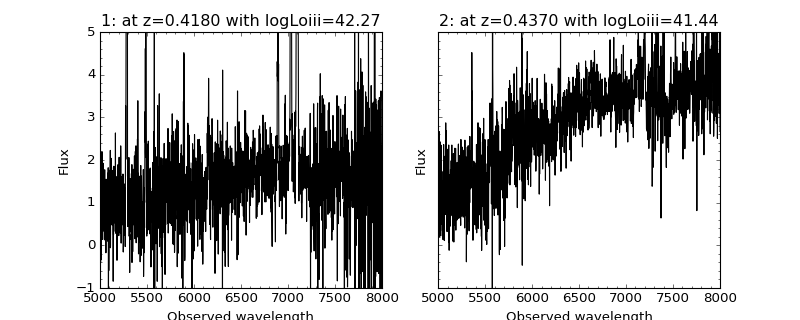


As you can see, zooming in on the y-axis now highlights
the continuum emission which is from starlight in the
quasar host galaxy. Note that in most quasars it is
hard to see emission from starlight because emission
from the quasar accretion disk is so much brighter.
But in obscured quasar, dust near the nucleus in the blocks
the accretion disk from our view and allows us to see
starlight more easily.

But even so, the starlight is pretty faint, so the S/N
in the continuum is very low. This is why the zoomed-in
spectra don't look very good. So we are going to play
some tricks to get a higher S/N spectrum of the 'typical'
obscured quasar by calculating the average or median spectrum for a 
sample of obscured quasar. Then we can look at the average spectrum
in bins of quasar properties to see if the quasar is related to
the other properties observed in the spectra such as outflowing gas
or even the host galaxy mass.

But first we have to put the different
quasar spectra on the same scale

In [7]:
## Now we are going to zoom in on the same spectra.

# Create a two panel figure, one for each quasar with x and y range initially the same
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

# Plot the first quasar
ax1.plot(spec1['wave'], spec1['flux'], color='black')
ax1.set_xlabel('Observed wavelength')
ax1.set_ylabel('Flux')
ax1.set_title('1: at z={:0.4f} with logLoiii={:0.2f}'.format(quasar1['redshift'], quasar1['logl_oiii']))
ax1.minorticks_on()

# Plot the second quasar
ax2.plot(spec2['wave'], spec2['flux'], color='black')
ax2.set_xlabel('Observed wavelength')
ax2.set_ylabel('Flux')
ax2.set_title('2: at z={:0.4f} with logLoiii={:0.2f}'.format(quasar2['redshift'], quasar2['logl_oiii']))

ax1.set_ylim([-1, 5])
ax1.set_xlim([5000, 8000])
print """
As you can see, zooming in on the y-axis now highlights
the continuum emission which is from starlight in the
quasar host galaxy. Note that in most quasars it is
hard to see emission from starlight because emission
from the quasar accretion disk is so much brighter.
But in obscured quasar, dust near the nucleus in the blocks
the accretion disk from our view and allows us to see
starlight more easily.

But even so, the starlight is pretty faint, so the S/N
in the continuum is very low. This is why the zoomed-in
spectra don't look very good. So we are going to play
some tricks to get a higher S/N spectrum of the 'typical'
obscured quasar by calculating the average or median spectrum for a 
sample of obscured quasar. Then we can look at the average spectrum
in bins of quasar properties to see if the quasar is related to
the other properties observed in the spectra such as outflowing gas
or even the host galaxy mass.

But first we have to put the different
quasar spectra on the same scale by using rest-frame wavelength and
'normalizing' the spectra. We'll do each of these one step at a time.

First, remember that in the previous Figure we saw that the emission
lines occured as slightly different wavelengths for the two quasars.
This is because they are at different redshifts. So before we average
the spectra, we need to go into the rest-frame. This is why the
getSpectrum function defined earlier has columns for the rest
wavelength (which is just the observed wavelength divided by 1+z)

"""

In [8]:
# First, we will define a function that retrieves a bunch of spectra
# and puts them into a common rest-wavelength grid so that we can compute
# average.
# The inputs are the rest-wavelength grid that we want the spectra on
# and a list of quasars
def getRestSpectra(wave_rest, quasars_in):
    
    # Create a 2-D array to store the spectrum of each quasar
    fluxArray = np.zeros((len(wave_rest), len(quasars_in)))
    
    # Loop through the quasars and retrieve the spectra
    for i in range(len(quasars_in)):
        quasar = quasars[i]
        spec = getSpectrum(quasar['plate'], quasar['mjd'], quasar['fiberid'], quasar['redshift']) # Get the spectrum in the rest-frame
        spec_interp = interp1d(spec['wave_rest'], spec['flux'],
                              bounds_error=False, 
                              fill_value=(np.nan, np.nan)) # Interpolate into common wavelength grid.
        fluxArray[:, i] = spec_interp(wave_rest)
        i = i + 1
    
    return fluxArray


<IPython.core.display.Javascript object>


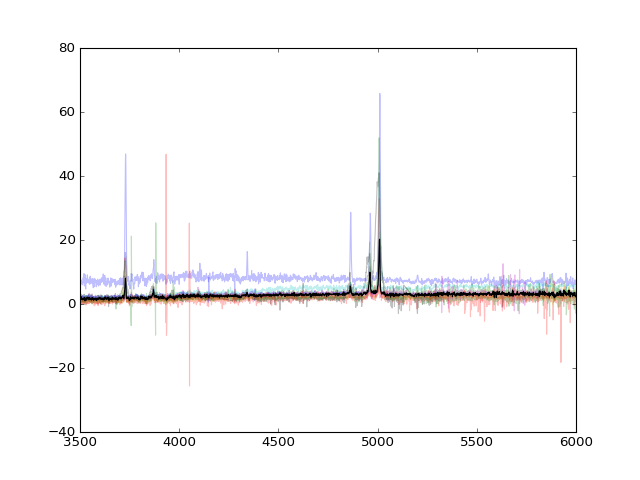


Here, we are plotting each individual spectrum in multi-color semi-tranparent line
and the median in non-transparent black line. The main thing that should be clear
from this is that there is a lot of scatter in the continuum levels. We will want
remove that by normalizing over some wavelength range. So lets do that with a new function.



In [9]:

## Get the first 10 spectra and plot them all
wave_rest = np.arange(3500, 6000, 1.0) # Get a wavelength array from 3500 to 7000 Angstrom with pixel spacing of 1 Angstrom
quasars_toCoadd = quasars_04[0:10]
fluxArray = getRestSpectra(wave_rest, quasars_toCoadd)
#print fluxArray
#print fluxArray.shape
fig, ax = plt.subplots(1)
for i in range(len(quasars_toCoadd)):
    

    ax.plot(wave_rest, fluxArray[:, i], alpha=0.25)
    
flux_median = np.nanmedian(fluxArray, axis=1) # Compute the median, excluding nan

ax.plot(wave_rest, flux_median, c='black')

print """
Here, we are plotting each individual spectrum in multi-color semi-tranparent line
and the median in non-transparent black line. The main thing that should be clear
from this is that there is a lot of scatter in the continuum levels. We will want
remove that by normalizing over some wavelength range. So lets do that with a new function.
"""


In [15]:
# First, we will define a function that retrieves a bunch of spectra
# and puts them into a common rest-wavelength grid so that we can compute
# average.
# The inputs are the rest-wavelength grid that we want the spectra on
# and a list of quasars
# And a region over with to compute the normalization.
def getRestSpectraNormed(wave_rest, quasars_in, wave_norm0, wave_norm1):
    
    # Create a 2-D array to store the spectrum of each quasar
    fluxArray = np.zeros((len(wave_rest), len(quasars_in)))
    
    # Loop through the quasars and retrieve the spectra
    for i in range(len(quasars_in)):
        quasar = quasars[i]
        print '{}/{} getting {}-{}-{}'.format(i+1, len(quasars_in), quasar['plate'], quasar['mjd'], quasar['fiberid'])
        spec = getSpectrum(quasar['plate'], quasar['mjd'], quasar['fiberid'], quasar['redshift']) # Get the spectrum in the rest-frame
        
        # Find the flux to normalized
        index = np.where((spec['wave_rest'] > wave_norm0) & (spec['wave_rest'] < wave_norm1))
        fluxToNorm = np.nanmedian(spec[index]['flux'])
        spec['flux'] = spec['flux']/fluxToNorm
        
        spec_interp = interp1d(spec['wave_rest'], spec['flux'],
                              bounds_error=False, 
                              fill_value=(np.nan, np.nan)) # Interpolate into common wavelength grid.
        fluxArray[:, i] = spec_interp(wave_rest)
        i = i + 1
    
    return fluxArray

1/303 getting 653-52145-149
2/303 getting 688-52203-590
3/303 getting 688-52203-21
4/303 getting 3586-55181-429
5/303 getting 1905-53706-285
6/303 getting 3590-55201-561
7/303 getting 692-52201-306
8/303 getting 4224-55481-220
9/303 getting 692-52201-548
10/303 getting 692-52201-591
11/303 getting 692-52201-615
12/303 getting 658-52146-572
13/303 getting 695-52202-282
14/303 getting 695-52202-227
15/303 getting 695-52202-497
16/303 getting 696-52209-243
17/303 getting 399-51817-438
18/303 getting 696-52209-498
19/303 getting 400-51820-197
20/303 getting 698-52203-400
21/303 getting 4231-55444-460
22/303 getting 4231-55444-612
23/303 getting 698-52203-95
24/303 getting 426-51882-590
25/303 getting 699-52202-235
26/303 getting 4232-55447-633
27/303 getting 699-52202-444
28/303 getting 664-52174-68
29/303 getting 4232-55447-218
30/303 getting 700-52199-18
31/303 getting 700-52199-4
32/303 getting 427-51900-323
33/303 getting 666-52149-131
34/303 getting 667-52163-135
35/303 getting 702-52

<IPython.core.display.Javascript object>


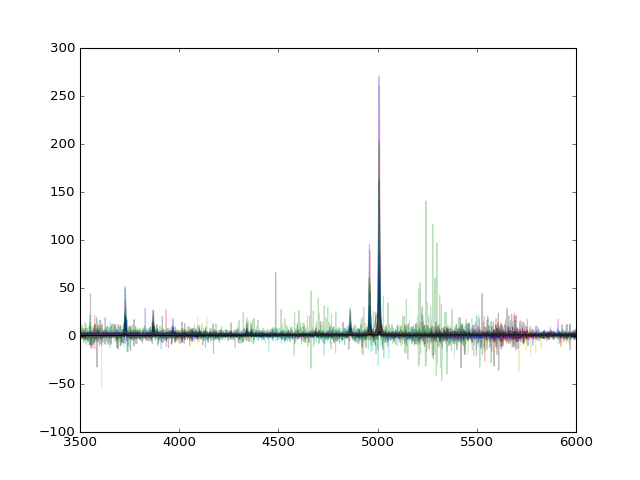


Here, we are plotting each individual spectrum in multi-color semi-tranparent line
and the median in non-transparent black line as before. But all the spectra should
fall pretty much on top of one another and the coadd will be more clear.

Compare the S/N in the continuum with the individual spectra. It should have less scatter by ~sqrt(10)




In [16]:
## Get the first 10 spectra and plot them all and coadd to get the median spectrum
wave_rest = np.arange(3500, 6000, 1.0) # Get a wavelength array from 3500 to 7000 Angstrom with pixel spacing of 1 Angstrom
quasars_toCoadd_low = lil_quasars

# We will normalize from 5100-5500 Ang since this is a nice line free region.
fluxArray = getRestSpectraNormed(wave_rest, quasars_toCoadd_low, 5100, 5500)
#print fluxArray
#print fluxArray.shape
fig, ax = plt.subplots(1)
for i in range(len(quasars_toCoadd_low)):
    

    ax.plot(wave_rest, fluxArray[:, i], alpha=0.25)
    
flux_median = np.nanmedian(fluxArray, axis=1) # Compute the median, excluding nan

ax.plot(wave_rest, flux_median, c='black')

print """
Here, we are plotting each individual spectrum in multi-color semi-tranparent line
and the median in non-transparent black line as before. But all the spectra should
fall pretty much on top of one another and the coadd will be more clear.

Compare the S/N in the continuum with the individual spectra. It should have less scatter by ~sqrt(10)

"""


1/100 getting 653-52145-149
2/100 getting 688-52203-590
3/100 getting 688-52203-21
4/100 getting 3586-55181-429
5/100 getting 1905-53706-285
6/100 getting 3590-55201-561
7/100 getting 692-52201-306
8/100 getting 4224-55481-220
9/100 getting 692-52201-548
10/100 getting 692-52201-591
11/100 getting 692-52201-615
12/100 getting 658-52146-572
13/100 getting 695-52202-282
14/100 getting 695-52202-227
15/100 getting 695-52202-497
16/100 getting 696-52209-243
17/100 getting 399-51817-438
18/100 getting 696-52209-498
19/100 getting 400-51820-197
20/100 getting 698-52203-400
21/100 getting 4231-55444-460
22/100 getting 4231-55444-612
23/100 getting 698-52203-95
24/100 getting 426-51882-590
25/100 getting 699-52202-235
26/100 getting 4232-55447-633
27/100 getting 699-52202-444
28/100 getting 664-52174-68
29/100 getting 4232-55447-218
30/100 getting 700-52199-18
31/100 getting 700-52199-4
32/100 getting 427-51900-323
33/100 getting 666-52149-131
34/100 getting 667-52163-135
35/100 getting 702-52

<IPython.core.display.Javascript object>


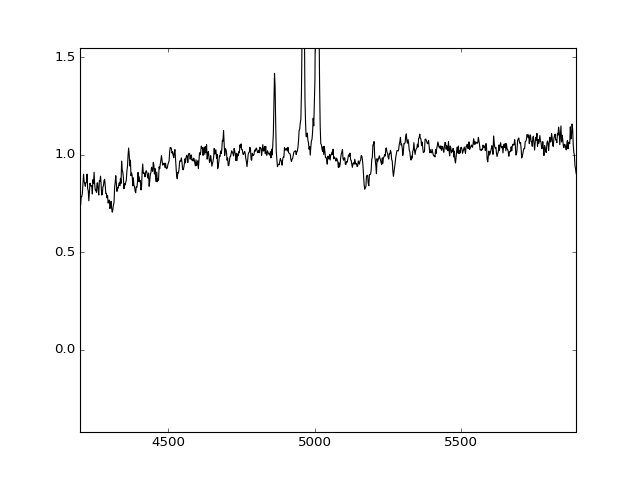


The S/N in the continuum should be much much better now!



In [15]:
## Do the same thing but now for 100 spectra. (this will take a while!!)
wave_rest = np.arange(3000, 8000, 2.0) # Get a wavelength array from 3500 to 7000 Angstrom with pixel spacing of 1 Angstrom
quasars_toCoadd = quasars_04[0:100]

# We will normalize from 5100-5500 Ang since this is a nice line free region.
fluxArray = getRestSpectraNormed(wave_rest, quasars_toCoadd, 5100, 5500)
#print fluxArray
#print fluxArray.shape
fig, ax = plt.subplots(1)
    
flux_median = np.nanmedian(fluxArray, axis=1) # Compute the median, excluding nan

ax.plot(wave_rest, flux_median, c='black')

print """
The S/N in the continuum should be much much better now!
"""

1/303 getting 653-52145-149
2/303 getting 688-52203-590
3/303 getting 688-52203-21
4/303 getting 3586-55181-429
5/303 getting 1905-53706-285
6/303 getting 3590-55201-561
7/303 getting 692-52201-306
8/303 getting 4224-55481-220
9/303 getting 692-52201-548
10/303 getting 692-52201-591
11/303 getting 692-52201-615
12/303 getting 658-52146-572
13/303 getting 695-52202-282
14/303 getting 695-52202-227
15/303 getting 695-52202-497
16/303 getting 696-52209-243
17/303 getting 399-51817-438
18/303 getting 696-52209-498
19/303 getting 400-51820-197
20/303 getting 698-52203-400
21/303 getting 4231-55444-460
22/303 getting 4231-55444-612
23/303 getting 698-52203-95
24/303 getting 426-51882-590
25/303 getting 699-52202-235
26/303 getting 4232-55447-633
27/303 getting 699-52202-444
28/303 getting 664-52174-68
29/303 getting 4232-55447-218
30/303 getting 700-52199-18
31/303 getting 700-52199-4
32/303 getting 427-51900-323
33/303 getting 666-52149-131
34/303 getting 667-52163-135
35/303 getting 702-52

<IPython.core.display.Javascript object>


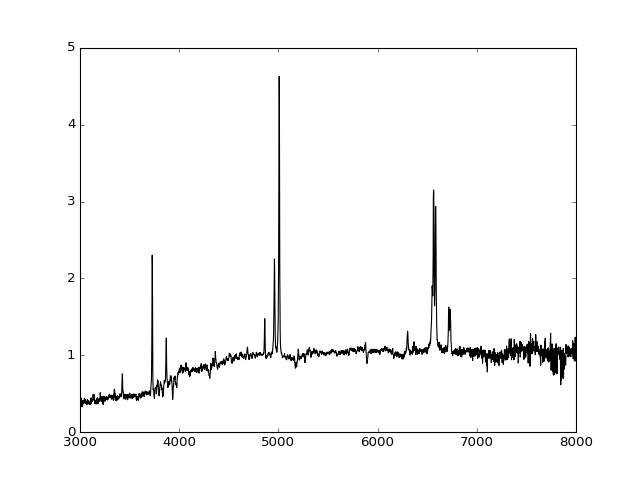


The S/N in the continuum should be much much better now!!!!!!!!



In [17]:
## Do the same thing but now for all the z~0.4 quasars. (this really will take a while)
## Get the first 10 spectra and plot them all and coadd to get the median spectrum
wave_rest = np.arange(3000, 8000, 2.0) # Get a wavelength array from 3500 to 7000 Angstrom with pixel spacing of 1 Angstrom


# We will normalize from 5100-5500 Ang since this is a nice line free region.
fluxArray = getRestSpectraNormed(wave_rest, quasars_toCoadd_low, 5100, 5500)
#print fluxArray
#print fluxArray.shape
fig, ax = plt.subplots(1)
    
flux_median = np.nanmedian(fluxArray, axis=1) # Compute the median, excluding nan

ax.plot(wave_rest, flux_median, c='black')

print """
The S/N in the continuum should be much much better now!!!!!!!!
"""


In [14]:
### Try to create stacks in bins of luminosity at fixed redshift to see if the spectra look any different!